# Tutorial | Simple pendulum

###### *example taken from [Arby](https://arby.readthedocs.io/en/latest/)

In this example we will build a reduced model for a simple pendulum using Scikit-ReducedModel. 

This system can be described by the ordinary differential equation (ODE)

\begin{equation}
\ddot{\theta} = -b\dot{\theta} - \frac{g}{l} \sin{\theta}
\end{equation}

where $g, l$ denote the gravity strenght and the pendulum longitude, respectively. The parameter $b$ is the damping factor.

We can decompose the 2nd order ODE above in two 1st order ODEs leading to the
desired pendulum equations

\begin{align}
\dot{\theta} &= \omega \\
\dot{\omega} &= -b \omega - \lambda \sin{\theta}
\end{align}

We import the necessary packages to make plots and solve differential equations.

In [5]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import odeint

Let's define the ODE system and fix some initial conditions

In [6]:
def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b*ω - λ*np.sin(θ)]

    return dydt

In [7]:
# set friction strength
b = 0.2
# set initial conditions
y0 = [np.pi/2, 0.]

In [8]:
# set a time discretization
times = np.linspace(0,50,1001)

In [9]:
# plot a simple solution
λ = 1.
sol = odeint(pend,y0, times, (b,λ))

Lets see how a solution looks

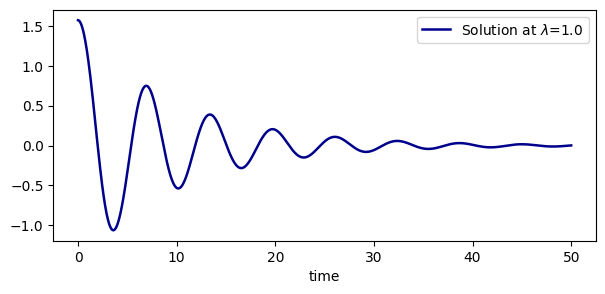

In [15]:
plt.figure(figsize=(7,3))
plt.plot(times, sol[:,0], label=f'Solution at $\lambda$={λ}', lw=1.8, color='darkblue')
plt.xlabel('time')
plt.legend()

### Building the Surrogate Model

To build a reduced model we will first need to build a reduced basis, then an empirical interpolator and finally we will build the model. So we will first import the necessary modules and build the base.

In [16]:
from skreducedmodel.reducedbasis import ReducedBasis
from skreducedmodel.empiricalinterpolation import EmpiricalInterpolation
from skreducedmodel.surrogate import Surrogate

in order of construct the reduced basis we define a discretization of the parametric domain and build a training set.

In [17]:
param = np.linspace(1,5,101)
training = []
for λ in param:
    sol = odeint(pend,y0, times, (b,λ))
    training.append(sol[:,0])

Instantiate the ReducedBasis class (in this case with default parameters) and create the reduced base. 

In [39]:
rb = ReducedBasis()

rb.fit(training_set = np.array(training),
       parameters = param,
       physical_points = times
       )

We plot some of the elements of the reduced base

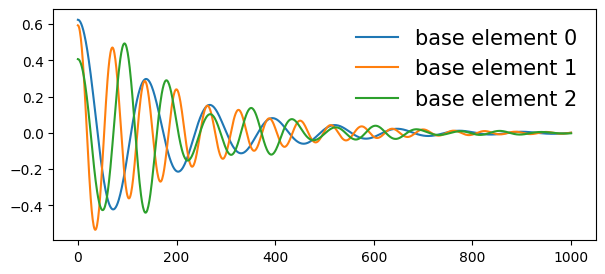

In [45]:
plt.figure(figsize=(7,3))
plt.plot(rb.tree.basis[0],label='base element 0')
plt.plot(rb.tree.basis[1],label='base element 1')
plt.plot(rb.tree.basis[2],label='base element 2')
plt.legend(fontsize=15,frameon=False)

We will now construct the empirical interpolator from our reduced base.

In [47]:
eim = EmpiricalInterpolation(rb)

eim.fit()

And finally, we build our surrogate model from our empirical interpolator.

In [55]:
model = Surrogate(eim)

model.fit()

We choose one of the parameters with which the model has not been trained, e.g. 3.42, and plot the original solution and the one predicted by our model.

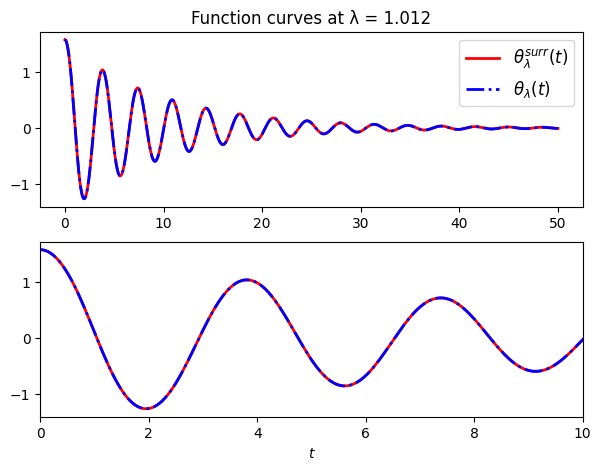

In [65]:
q = 3.42


sol = odeint(pend,y0, times, (b,q))[:,0]
fig, ax = plt.subplots(2,1, figsize=(7,5))
ax[0].plot(times, model.predict(q), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[0].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].plot(times, model.predict(q), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[1].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].set(xlim=(0,10))
ax[1].set(xlabel='$t$')
ax[0].set_title('Function curves at λ = 1.012')
ax[0].legend(fontsize = 'large')



This example serves to demonstrate the process of constructing surrogate models. In case you are not interested in the ReducedBasis and EmpiricalInterpolation classes and only want to work with the surrogate model, you can work directly with the mkreducedmodel() function: